# Baseline (gpt-4o-mini and gpt-4o API same as Generative phase)

## MCQ multimodal and unimodal questions

In [1]:
import os, json, re, unicodedata
from pathlib import Path
from typing import List, Dict, Any
import pandas as pd
import numpy as np
import httpx
from openai import OpenAI

In [2]:
BASE    = Path(r"G:\My Drive\NLP\project")
OUT_DIR = BASE / "rag_out/baseline/"
OUT_DIR.mkdir(parents=True, exist_ok=True)

TEXT_Q_JSON   = BASE / "Questions/mcq_questions_90.json"
MULTI_Q_JSON  = BASE / "Questions/mcq_with_image_50_final.json"

BASELINE_TEXT_CSV  = OUT_DIR / "baseline_text_MCQ_outputs.csv"
BASELINE_MULTI_CSV = OUT_DIR / "baseline_multimodal_MCQ_outputs.csv"

In [3]:
API_KEY  = "sk-vJOliUFA4EZC9CXa57qbNpJE2hhtmUyjW7qAyLSEfXfUYBwV"
BASE_URL = "https://api.gapgpt.app/v1"
MODEL    = "gpt-4o-mini"

client = OpenAI(base_url=BASE_URL, api_key=API_KEY)

In [4]:
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": "سلام!"}
    ]
)

print(response.choices[0].message.content)

سلام! چطور می‌تونم کمکتون کنم؟ 😊


In [5]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
CTRL_RE = re.compile(r"[\u200c\u200d\u200e\u202a-\u202e]")

def norm_str(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = CTRL_RE.sub("", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def ensure_in_options(pred: str, options: List[str]) -> str:
    if pred in options: return pred
    pred_n = norm_str(pred)
    opts_n = list(map(norm_str, options))
    return options[opts_n.index(pred_n)] if pred_n in opts_n else ""

def build_zero_shot_text_prompt(question: str, options: List[str]) -> List[Dict[str, Any]]:
    user_text = (
        "فقط با استفاده از اطلاعات عمومی خود و بدون هیچ متنی از منبع بیرونی، "
        "به پرسش زیر پاسخ بده. یکی از چهار گزینه را به عنوان پاسخ درست انتخاب کن.\n\n"
        f"سؤال:\n{question}\n\n"
        "گزینه‌ها:\n" + "\n".join(f"- {o}" for o in options) + "\n\n"
        "خروجی فقط JSON باشد:\n"
        '{ "predicted_option": "یکی از گزینه‌ها دقیقا", "rationale": "توضیح کوتاه اختیاری" }'
    )
    return [
        {"role":"system","content":"You are a helpful assistant. Respond ONLY in JSON."},
        {"role":"user","content": user_text}
    ]

def build_zero_shot_multi_prompt(question: str, options: List[str]) -> str:
    # The text that accompanies the image (if image is used)
    return (
        "با توجه به تصویر (در صورت وجود) و فقط با دانش عمومی خود، "
        "به پرسش زیر پاسخ بده و از بین چهار گزینه یکی را انتخاب کن.\n\n"
        f"سؤال:\n{question}\n\n"
        "گزینه‌ها:\n" + "\n".join(f"- {o}" for o in options) + "\n\n"
        "خروجی فقط JSON باشد:\n"
        '{ "predicted_option": "یکی از گزینه‌ها دقیقا", "rationale": "توضیح کوتاه اختیاری" }'
    )


In [6]:
def parse_json_strictish(txt: str) -> Dict[str, Any]:
    import json, re
    t = (txt or "").strip()
    if t.startswith("```"):
        t = re.sub(r"^```(?:json)?\s*|\s*```$", "", t, flags=re.DOTALL)
    try:
        obj = json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, flags=re.DOTALL)
        obj = json.loads(m.group(0)) if m else {"predicted_option":"", "rationale": t}
    obj.setdefault("predicted_option","")
    obj.setdefault("rationale","")
    return obj

def chat_json(messages, temperature=0.0, use_json_format=True, timeout_s=120):
    try:
        resp = client.chat.completions.create(
            model=MODEL,
            messages=messages,
            temperature=temperature,
            response_format={"type":"json_object"} if use_json_format else None,
            timeout=timeout_s,
        )
        return parse_json_strictish(resp.choices[0].message.content)
    except Exception:
        # Fallback without response_format
        resp = client.chat.completions.create(
            model=MODEL,
            messages=messages,
            temperature=temperature,
            timeout=timeout_s,
        )
        return parse_json_strictish(resp.choices[0].message.content)

In [7]:
USE_SELF_CONSISTENCY = False
SC_SAMPLES = 5
SC_TEMPERATURE = 0.7

SUPPORTS_IMAGE_MESSAGES = True

In [8]:
text_q = json.loads(TEXT_Q_JSON.read_text(encoding="utf-8"))
text_rows = []
for rec in text_q:
    q = rec.get("question","").strip()
    opts = list(rec.get("options", []))
    gold = rec.get("answer","")

    if not USE_SELF_CONSISTENCY:
        msgs = build_zero_shot_text_prompt(q, opts)
        obj  = chat_json(msgs, temperature=0.0)
        pred = ensure_in_options(obj.get("predicted_option",""), opts)
        text_rows.append({
            "question": q,
            "predicted_option": pred,
            "rationale": obj.get("rationale",""),
            "gold_answer": gold,
            "is_correct": int(norm_str(pred)==norm_str(gold))
        })
    else:
        votes = []
        rats  = []
        for _ in range(SC_SAMPLES):
            msgs = build_zero_shot_text_prompt(q, opts)
            obj  = chat_json(msgs, temperature=SC_TEMPERATURE, use_json_format=False)
            pred = ensure_in_options(obj.get("predicted_option",""), opts)
            if pred: votes.append(pred)
            rats.append(obj.get("rationale",""))
        # majority vote
        if votes:
            pred = pd.Series(votes).mode().iloc[0]
        else:
            pred = ""
        text_rows.append({
            "question": q,
            "predicted_option": pred,
            "rationale": " | ".join(rats[:2]),
            "gold_answer": gold,
            "is_correct": int(norm_str(pred)==norm_str(gold))
        })

pd.DataFrame(text_rows).to_csv(BASELINE_TEXT_CSV, index=False, encoding="utf-8-sig")
print("Saved:", BASELINE_TEXT_CSV)

Saved: G:\My Drive\NLP\project\rag_out\baseline\baseline_text_MCQ_outputs.csv


In [9]:
def accuracy_from_csv(pred_csv: Path, gold_json: Path, join_on=("question",), extra_merge=None):
    preds = pd.read_csv(pred_csv, dtype=str, keep_default_na=False)
    gold  = pd.DataFrame(json.loads(gold_json.read_text(encoding="utf-8")))
    for c in join_on:
        preds[c+"_n"] = preds[c].map(norm_str)
        gold[c+"_n"]  = gold[c].map(norm_str)
    on_cols = [c+"_n" for c in join_on]
    df = preds.merge(gold[on_cols+["answer"]].drop_duplicates(on_cols), on=on_cols, how="left")
    acc = float((df.apply(lambda r: norm_str(r.get("predicted_option",""))==norm_str(r.get("answer","")), axis=1)).mean())
    return acc

In [10]:
text_acc_base  = accuracy_from_csv(BASELINE_TEXT_CSV, TEXT_Q_JSON, join_on=("question",))
print(f"Baseline accuracy — Text:       {text_acc_base:.3f}")

Baseline accuracy — Text:       0.567


In [11]:
multi_q = json.loads(MULTI_Q_JSON.read_text(encoding="utf-8"))
multi_rows = []

counter = 1

for rec in multi_q:
    q = rec.get("question","").strip()
    opts = list(rec.get("options", []))
    gold = rec.get("answer","")
    img_url = rec.get("image_url","")

    # Build content with optional image
    text_part = build_zero_shot_multi_prompt(q, opts)

    def try_image_call() -> Dict[str,Any]:
        # Attempt OpenAI-style image input; if the endpoint doesn't support it, this call may raise
        messages = [{
            "role": "system",
            "content": "You are a helpful assistant. Respond ONLY in JSON."
        }, {
            "role": "user",
            "content": [
                {"type": "text", "text": text_part},
                # Include image only if configured
                *([{"type":"image_url","image_url":{"url": img_url}}] if (SUPPORTS_IMAGE_MESSAGES and img_url) else [])
            ]
        }]
        return chat_json(messages, temperature=0.0)

    def text_only_call() -> Dict[str,Any]:
        messages = [
            {"role":"system","content":"You are a helpful assistant. Respond ONLY in JSON."},
            {"role":"user","content": text_part}
        ]
        return chat_json(messages, temperature=0.0)

    try:
        obj = try_image_call()
    except Exception:
        obj = text_only_call()

    pred = ensure_in_options(obj.get("predicted_option",""), opts)

    print(f"predicted option for {counter}: {pred}")
    counter += 1
    
    multi_rows.append({
        "question": q,
        "image_url": img_url,
        "predicted_option": pred,
        "rationale": obj.get("rationale",""),
        "gold_answer": gold,
        "is_correct": int(norm_str(pred)==norm_str(gold))
    })

pd.DataFrame(multi_rows).to_csv(BASELINE_MULTI_CSV, index=False, encoding="utf-8-sig")
print("Saved:", BASELINE_MULTI_CSV)

predicted option for 1: نیما یوشیج شاعر
predicted option for 2: علی دایی
predicted option for 3: امیر یاوری
predicted option for 4: امیر عابدزاده، پرسپولیس
predicted option for 5: رزیتا علیپور، کاراته
predicted option for 6: حامد حدادی ، بسکتبال
predicted option for 7: جاسم امیری، تهران
predicted option for 8: زهره کودایی سپاهان
predicted option for 9: حمید درخشان
predicted option for 10: رضا حقیقی فوتبال
predicted option for 11: فرشاد احمدزاده ارومیه
predicted option for 12: علیرضا منصوریان پارس شتاتآیزن
predicted option for 13: تهران
predicted option for 14: آریا داوری کشتی
predicted option for 15: علی علیپور 29 سال
predicted option for 16: حجت صدقی
predicted option for 17: الهام فلاح والیبال
predicted option for 18: این فرد علی انصاریان است و در تیم استقلال بازی کرده است.
predicted option for 19: سردار آزمون گنبد کاووس
predicted option for 20: رامین رضاییان فوتبال
predicted option for 21: رحمان احمدی
predicted option for 22: رعنا آزادیور زخم کاری
predicted option for 23: پرویز پرستو

In [12]:
multi_acc_base = accuracy_from_csv(BASELINE_MULTI_CSV, MULTI_Q_JSON, join_on=("question","image_url"))
print(f"Baseline accuracy — Multimodal: {multi_acc_base:.3f}")

Baseline accuracy — Multimodal: 0.660


## Multimodal without-options questions

In [27]:
import os, json, re, unicodedata
from pathlib import Path
from typing import Dict, Any, List
import pandas as pd
from openai import OpenAI

In [28]:
BASE    = Path(r"G:\My Drive\NLP\project")
OUT_DIR = BASE / "rag_out/baseline/"
OUT_DIR.mkdir(parents=True, exist_ok=True)

MULTI_FREE_JSON = BASE / "Questions/multi_with_image_50_newV.json"
BASELINE_FREE_CSV = OUT_DIR / "baseline_multimodal_NO_OPTIONS_outputs.csv"

In [29]:
API_KEY  = "sk-vJOliUFA4EZC9CXa57qbNpJE2hhtmUyjW7qAyLSEfXfUYBwV"
BASE_URL = "https://api.gapgpt.app/v1"
MODEL    = "gpt-4o"  # answering model
JUDGE_MODEL = "gpt-4o-mini"  # judge model

In [30]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
CTRL_RE = re.compile(r"[\u200c\u200d\u200e\u202a-\u202e]")

def norm_str(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = CTRL_RE.sub("", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_yesno(txt: str) -> str:
    """Return 'بله' / 'خیر' / '' (robust to noise)."""
    t = norm_str(txt).lower()
    # direct checks
    if "بله" in t or "yes" in t:
        return "بله"
    if "خیر" in t or "خير" in t or "no" in t:
        return "خیر"
    # exact raw fallback
    if txt.strip() in ("بله","خیر","خير","Yes","No","YES","NO"):
        return "بله" if txt.strip().lower()=="yes" else ("خیر" if txt.strip().lower()=="no" or txt.strip()=="خير" else txt.strip())
    return ""

def chat_string(messages: List[Dict[str, Any]], model: str, temperature: float = 0.0, timeout_s: int = 120) -> str:
    """Single string response (no JSON enforced)."""
    resp = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        timeout=timeout_s,
    )
    return (resp.choices[0].message.content or "").strip()

SUPPORTS_IMAGE_MESSAGES = True

def build_qa_text(question: str) -> str:
    return (
        "با توجه به تصویر (در صورت وجود)، به پرسش زیر کوتاه و دقیق پاسخ بده. "
        "اگر جواب واضح نیست، بهترین پاسخ احتمالی را بده؛ از توضیح طولانی خودداری کن.\n\n"
        f"سؤال:\n{question}"
    )

def answer_with_image_or_text(question: str, image_url: str) -> str:
    """Try image+text. If it fails, fall back to text-only."""
    user_payload: Any
    if SUPPORTS_IMAGE_MESSAGES and image_url:
        user_payload = [
            {"type": "text", "text": build_qa_text(question)},
            {"type": "image_url", "image_url": {"url": image_url, "detail": "low"}}
        ]
    else:
        user_payload = build_qa_text(question)

    try:
        return chat_string(
            [
                {"role": "system", "content": "You are a helpful assistant. Answer in Persian briefly."},
                {"role": "user", "content": user_payload},
            ],
            model=MODEL,
            temperature=0.0
        )
    except Exception:
        # fallback: text-only (no image)
        return chat_string(
            [
                {"role": "system", "content": "You are a helpful assistant. Answer in Persian briefly."},
                {"role": "user", "content": build_qa_text(question)},
            ],
            model=MODEL,
            temperature=0.0
        )

def judge_equivalence(model_answer: str, gold_answer: str) -> str:
    """
    LLM-as-a-judge: returns 'بله' or 'خیر'.
    We instruct the model to only return one word; parser is still robust.
    """
    prompt = (
        "من یک جواب با استفاده از مدل هوش مصنوعی استخراج کرده‌ام و یک جواب طلایی برای سؤال وجود دارد. "
        "بدون هیچ توضیح اضافه و فقط با یک کلمه «بله» یا «خیر» بگو که آیا جواب استخراج‌شده من از لحاظ منطقی "
        "با جواب طلایی یکسان است؟ (لازم نیست دقیقاً یکی باشد؛ فقط منطقی و معادل باشد)\n\n"
        f"جواب مدل من:\n{model_answer}\n\n"
        f"جواب طلایی:\n{gold_answer}"
    )
    raw = chat_string(
        [
            {"role": "system", "content": "فقط و فقط با یک کلمه پاسخ بده: «بله» یا «خیر»."},
            {"role": "user", "content": prompt},
        ],
        model=JUDGE_MODEL,
        temperature=0.0
    )
    yn = parse_yesno(raw)
    return yn if yn in ("بله","خیر") else "خیر"

In [23]:
assert MULTI_FREE_JSON.exists(), f"Missing questions file: {MULTI_FREE_JSON}"
items = json.loads(MULTI_FREE_JSON.read_text(encoding="utf-8"))

In [24]:
rows = []

counter = 1

for i, rec in enumerate(items, start=1):
    q         = (rec.get("question") or "").strip()
    img_url   = (rec.get("image_url") or "").strip()
    gold_ans  = (rec.get("answer") or "").strip()
    gold_name = (rec.get("answer_name") or "").strip()
    category  = (rec.get("category") or "").strip()

    model_ans = answer_with_image_or_text(q, img_url)
    verdict   = judge_equivalence(model_ans, gold_ans)
    is_ok     = 1 if verdict == "بله" else 0

    print(f"[{i}/{len(items)}] verdict={verdict} | Q: {q[:40]}... | A(model): {model_ans[:40]}...")

    print(f"Model answer for question {counter}: {model_ans}")
    print(f"Similarity judge for question {counter}: {verdict}")
    counter += 1
    
    rows.append({
        "question": q,
        "image_url": img_url,
        "gold_answer": gold_ans,
        "gold_answer_name": gold_name,
        "category": category,
        "model_answer": model_ans,
        "judge": verdict,
        "is_correct": is_ok,
    })

[1/50] verdict=خیر | Q: این چهره ی چه کسی است؟... | A(model): متأسفانه نمی‌توانم بگویم این چهره متعلق ...
Model answer for question 1: متأسفانه نمی‌توانم بگویم این چهره متعلق به چه کسی است.
Similarity judge for question 1: خیر
[2/50] verdict=خیر | Q: این چهره ی چه کسی است؟... | A(model): متأسفانه نمی‌توانم بگویم این چهره متعلق ...
Model answer for question 2: متأسفانه نمی‌توانم بگویم این چهره متعلق به چه کسی است.
Similarity judge for question 2: خیر
[3/50] verdict=خیر | Q: این چهره ی چه کسی است و در چه تیمی بازی ... | A(model): متأسفانه نمی‌توانم بگویم این چهره متعلق ...
Model answer for question 3: متأسفانه نمی‌توانم بگویم این چهره متعلق به چه کسی است.
Similarity judge for question 3: خیر
[4/50] verdict=بله | Q: این چهره ی چه کسی است و در چه رشته ای فع... | A(model): متأسفانه نمی‌توانم بگویم این چهره چه کسی...
Model answer for question 4: متأسفانه نمی‌توانم بگویم این چهره چه کسی است. اما به نظر می‌رسد که در رشته کاراته فعالیت می‌کند.
Similarity judge for question 4: بله
[5/50] verdict

### Change answering model (gets image) to gpt-4o

In [ ]:
API_KEY  = "sk-vJOliUFA4EZC9CXa57qbNpJE2hhtmUyjW7qAyLSEfXfUYBwV"
BASE_URL = "https://api.gapgpt.app/v1"
MODEL    = "gpt-4o"  # answering model
JUDGE_MODEL = "gpt-4o-mini"  # judge model

In [25]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
CTRL_RE = re.compile(r"[\u200c\u200d\u200e\u202a-\u202e]")

def norm_str(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = CTRL_RE.sub("", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_yesno(txt: str) -> str:
    """Return 'بله' / 'خیر' / '' (robust to noise)."""
    t = norm_str(txt).lower()
    # direct checks
    if "بله" in t or "yes" in t:
        return "بله"
    if "خیر" in t or "خير" in t or "no" in t:
        return "خیر"
    # exact raw fallback
    if txt.strip() in ("بله","خیر","خير","Yes","No","YES","NO"):
        return "بله" if txt.strip().lower()=="yes" else ("خیر" if txt.strip().lower()=="no" or txt.strip()=="خير" else txt.strip())
    return ""

def chat_string(messages: List[Dict[str, Any]], model: str, temperature: float = 0.0, timeout_s: int = 120) -> str:
    """Single string response (no JSON enforced)."""
    resp = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        timeout=timeout_s,
    )
    return (resp.choices[0].message.content or "").strip()

SUPPORTS_IMAGE_MESSAGES = True

def build_qa_text(question: str) -> str:
    return (
        "با توجه به تصویر (در صورت وجود)، به پرسش زیر کوتاه و دقیق پاسخ بده. "
        "اگر جواب واضح نیست، بهترین پاسخ احتمالی را بده؛ از توضیح طولانی خودداری کن.\n\n"
        f"سؤال:\n{question}"
    )

def answer_with_image_or_text(question: str, image_url: str) -> str:
    """Try image+text. If it fails, fall back to text-only."""
    user_payload: Any
    if SUPPORTS_IMAGE_MESSAGES and image_url:
        user_payload = [
            {"type": "text", "text": build_qa_text(question)},
            *([{"type":"image_url","image_url":{"url": img_url}}] if (SUPPORTS_IMAGE_MESSAGES and img_url) else [])
        ]
    else:
        user_payload = build_qa_text(question)

    try:
        return chat_string(
            [
                {"role": "system", "content": "You are a helpful assistant. Answer in Persian briefly."},
                {"role": "user", "content": user_payload},
            ],
            model=MODEL,
            temperature=0.0
        )
    except Exception:
        # fallback: text-only (no image)
        return chat_string(
            [
                {"role": "system", "content": "You are a helpful assistant. Answer in Persian briefly."},
                {"role": "user", "content": build_qa_text(question)},
            ],
            model=MODEL,
            temperature=0.0
        )

def judge_equivalence(model_answer: str, gold_answer: str) -> str:
    """
    LLM-as-a-judge: returns 'بله' or 'خیر'.
    We instruct the model to only return one word; parser is still robust.
    """
    prompt = (
        "من یک جواب با استفاده از مدل هوش مصنوعی استخراج کرده‌ام و یک جواب طلایی برای سؤال وجود دارد. "
        "بدون هیچ توضیح اضافه و فقط با یک کلمه «بله» یا «خیر» بگو که آیا جواب استخراج‌شده من از لحاظ منطقی "
        "با جواب طلایی یکسان است؟ (لازم نیست دقیقاً یکی باشد؛ فقط منطقی و معادل باشد)\n\n"
        f"جواب مدل من:\n{model_answer}\n\n"
        f"جواب طلایی:\n{gold_answer}"
    )
    raw = chat_string(
        [
            {"role": "system", "content": "فقط و فقط با یک کلمه پاسخ بده: «بله» یا «خیر»."},
            {"role": "user", "content": prompt},
        ],
        model=JUDGE_MODEL,
        temperature=0.0
    )
    yn = parse_yesno(raw)
    return yn if yn in ("بله","خیر") else "خیر"

In [31]:
assert MULTI_FREE_JSON.exists(), f"Missing questions file: {MULTI_FREE_JSON}"
items = json.loads(MULTI_FREE_JSON.read_text(encoding="utf-8"))

In [32]:
rows = []

counter = 1

for i, rec in enumerate(items, start=1):
    q         = (rec.get("question") or "").strip()
    img_url   = (rec.get("image_url") or "").strip()
    gold_ans  = (rec.get("answer") or "").strip()
    gold_name = (rec.get("answer_name") or "").strip()
    category  = (rec.get("category") or "").strip()

    model_ans = answer_with_image_or_text(q, img_url)
    verdict   = judge_equivalence(model_ans, gold_ans)
    is_ok     = 1 if verdict == "بله" else 0

    print(f"[{i}/{len(items)}] verdict={verdict} | Q: {q[:40]}... | A(model): {model_ans[:40]}...")

    print(f"Model answer for question {counter}: {model_ans}")
    print(f"Similarity judge for question {counter}: {verdict}")
    counter += 1
    
    rows.append({
        "question": q,
        "image_url": img_url,
        "gold_answer": gold_ans,
        "gold_answer_name": gold_name,
        "category": category,
        "model_answer": model_ans,
        "judge": verdict,
        "is_correct": is_ok,
    })

[1/50] verdict=بله | Q: این چهره ی چه کسی است؟... | A(model): این تصویر مربوط به علی دایی است....
Model answer for question 1: این تصویر مربوط به علی دایی است.
Similarity judge for question 1: بله
[2/50] verdict=خیر | Q: این چهره ی چه کسی است؟... | A(model): تشخیص چهره با توجه به تصویر ممکن نیست....
Model answer for question 2: تشخیص چهره با توجه به تصویر ممکن نیست.
Similarity judge for question 2: خیر
[3/50] verdict=خیر | Q: این چهره ی چه کسی است و در چه تیمی بازی ... | A(model): این تصویر مربوط به بازیکن تیم ملی فوتبال...
Model answer for question 3: این تصویر مربوط به بازیکن تیم ملی فوتبال ایران است. بدون اطلاعات بیشتر، شناسایی دقیق ممکن نیست.
Similarity judge for question 3: خیر
[4/50] verdict=بله | Q: این چهره ی چه کسی است و در چه رشته ای فع... | A(model): این فرد احتمالاً کاراته‌کا است و در رشته...
Model answer for question 4: این فرد احتمالاً کاراته‌کا است و در رشته کاراته فعالیت می‌کند.
Similarity judge for question 4: بله
[5/50] verdict=خیر | Q: این چهره ی چه کسی است و در چه ر

In [33]:
df = pd.DataFrame(rows)
df.to_csv(BASELINE_FREE_CSV, index=False, encoding="utf-8-sig")
print("Saved:", BASELINE_FREE_CSV)

Saved: G:\My Drive\NLP\project\rag_out\baseline\baseline_multimodal_NO_OPTIONS_outputs.csv


In [34]:
acc = float(df["is_correct"].mean()) if len(df) else 0.0
print(f"Baseline accuracy — Multimodal (no options, LLM judge): {acc:.3f}")

Baseline accuracy — Multimodal (no options, LLM judge): 0.120


## Unimodal without-options questions

In [35]:
import os, json, re, unicodedata
from pathlib import Path
from typing import Dict, Any, List
import pandas as pd
from openai import OpenAI

In [36]:
BASE    = Path(r"G:\My Drive\NLP\project")
OUT_DIR = BASE / "rag_out/baseline/"
OUT_DIR.mkdir(parents=True, exist_ok=True)

UNI_FREE_JSON      = BASE / "Questions/uni_questions_110.json"
BASELINE_UNI_CSV   = OUT_DIR / "baseline_unimodal_NO_OPTIONS_outputs.csv"

In [37]:
API_KEY  = "sk-vJOliUFA4EZC9CXa57qbNpJE2hhtmUyjW7qAyLSEfXfUYBwV"
BASE_URL = "https://api.gapgpt.app/v1"
MODEL        = "gpt-4o-mini"   # answering model
JUDGE_MODEL  = "gpt-4o-mini"   # judge model

In [38]:
client = OpenAI(base_url=BASE_URL, api_key=API_KEY)

In [39]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
CTRL_RE = re.compile(r"[\u200c\u200d\u200e\u202a-\u202e]")

def norm_str(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = CTRL_RE.sub("", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_yesno(txt: str) -> str:
    """Return 'بله' / 'خیر' / '' (robust to noise)."""
    t = norm_str(txt).lower()
    if "بله" in t or "yes" in t:
        return "بله"
    if "خیر" in t or "خير" in t or "no" in t:
        return "خیر"
    if txt.strip() in ("بله","خیر","خير","Yes","No","YES","NO"):
        return "بله" if txt.strip().lower()=="yes" else ("خیر" if txt.strip().lower()=="no" or txt.strip()=="خير" else txt.strip())
    return ""

def chat_string(messages: List[Dict[str, Any]], model: str, temperature: float = 0.0, timeout_s: int = 120) -> str:
    """Single-string response (no JSON enforcement)."""
    resp = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        timeout=timeout_s,
    )
    return (resp.choices[0].message.content or "").strip()

def answer_text_only(question: str) -> str:
    """Answer a text-only question briefly in Persian."""
    prompt = (
        "به پرسش زیر کوتاه و دقیق پاسخ بده. اگر جواب روشن نیست، بهترین پاسخ احتمالی را بده؛ "
        "از توضیح طولانی خودداری کن.\n\n"
        f"سؤال:\n{question}"
    )
    return chat_string(
        [
            {"role": "system", "content": "You are a helpful assistant. Answer in Persian briefly."},
            {"role": "user", "content": prompt},
        ],
        model=MODEL,
        temperature=0.0
    )

def judge_equivalence(model_answer: str, gold_answer: str) -> str:
    """
    LLM-as-a-judge: returns 'بله' or 'خیر'.
    Conservative default to 'خیر' if parsing fails.
    """
    prompt = (
        "من یک جواب با استفاده از مدل هوش مصنوعی استخراج کرده‌ام و یک جواب طلایی برای سؤال وجود دارد. "
        "بدون هیچ توضیح اضافه و فقط با یک کلمه «بله» یا «خیر» بگو که آیا جواب استخراج‌شده من از لحاظ منطقی "
        "با جواب طلایی یکسان است؟ (لازم نیست دقیقاً یکی باشد؛ فقط منطقی و معادل باشد)\n\n"
        f"جواب مدل من:\n{model_answer}\n\n"
        f"جواب طلایی:\n{gold_answer}"
    )
    raw = chat_string(
        [
            {"role": "system", "content": "فقط و فقط با یک کلمه پاسخ بده: «بله» یا «خیر»."},
            {"role": "user", "content": prompt},
        ],
        model=JUDGE_MODEL,
        temperature=0.0
    )
    yn = parse_yesno(raw)
    return yn if yn in ("بله","خیر") else "خیر"

In [40]:
assert UNI_FREE_JSON.exists(), f"Missing questions file: {UNI_FREE_JSON}"
items = json.loads(UNI_FREE_JSON.read_text(encoding="utf-8"))

In [41]:
rows = []

counter = 1

for i, rec in enumerate(items, start=1):
    q        = (rec.get("question") or "").strip()
    gold_ans = (rec.get("answer") or "").strip()
    category = (rec.get("category") or "").strip()

    model_ans = answer_text_only(q)
    verdict   = judge_equivalence(model_ans, gold_ans)
    is_ok     = 1 if verdict == "بله" else 0

    print(f"[{i}/{len(items)}] verdict={verdict} | Q: {q[:40]}... | A(model): {model_ans[:40]}...")

    print(f"Model answer for question {counter}: {model_ans}")
    print(f"Similarity judge for question {counter}: {verdict}")
    counter += 1

    rows.append({
        "question": q,
        "gold_answer": gold_ans,
        "category": category,
        "model_answer": model_ans,
        "judge": verdict,     # "بله"/"خیر"
        "is_correct": is_ok,  # 1/0
    })

[1/110] verdict=خیر | Q: حبیب‌الله بلور در کدام رشته ورزشی فعالیت... | A(model): حبیب‌الله بلور در رشته وزنه‌برداری فعالی...
Model answer for question 1: حبیب‌الله بلور در رشته وزنه‌برداری فعالیت داشت.
Similarity judge for question 1: خیر
[2/110] verdict=خیر | Q: بهرنگ صفری در چه سالی متولد شده است؟... | A(model): بهرنگ صفری در سال ۱۳۶۲ متولد شده است....
Model answer for question 2: بهرنگ صفری در سال ۱۳۶۲ متولد شده است.
Similarity judge for question 2: خیر
[3/110] verdict=خیر | Q: عبدالله موحد چند مدال جهانی کسب کرده است... | A(model): عبدالله موحد دو مدال جهانی کسب کرده است....
Model answer for question 3: عبدالله موحد دو مدال جهانی کسب کرده است.
Similarity judge for question 3: خیر
[4/110] verdict=خیر | Q: لوون کورکچیان مدال طلای خود را در کدام ر... | A(model): لوون کورکچیان مدال طلای خود را در مسابقا...
Model answer for question 4: لوون کورکچیان مدال طلای خود را در مسابقات قهرمانی وزنه‌برداری جهان کسب کرده است.
Similarity judge for question 4: خیر
[5/110] verdict=خیر | Q: علیرضا حقی

In [42]:
df = pd.DataFrame(rows)
acc = float(df["is_correct"].mean()) if len(df) else 0.0
print(f"Baseline accuracy — Unimodal (no options, LLM judge): {acc:.3f}")

Baseline accuracy — Unimodal (no options, LLM judge): 0.073


In [43]:
BASELINE_UNI_CSV   = OUT_DIR / "baseline_unimodal_NO_OPTIONS_outputs_4o_mini.csv"
df.to_csv(BASELINE_UNI_CSV, index=False, encoding="utf-8-sig")
print("Saved:", BASELINE_UNI_CSV)

Saved: G:\My Drive\NLP\project\rag_out\baseline\baseline_unimodal_NO_OPTIONS_outputs_4o_mini.csv


### Change both models to gpt-4o

In [48]:
API_KEY  = "sk-vJOliUFA4EZC9CXa57qbNpJE2hhtmUyjW7qAyLSEfXfUYBwV"
BASE_URL = "https://api.gapgpt.app/v1"
MODEL        = "gpt-4o"   # answering model
JUDGE_MODEL  = "gpt-4o"   # judge model

client = OpenAI(base_url=BASE_URL, api_key=API_KEY)

BASELINE_UNI_CSV   = OUT_DIR / "baseline_unimodal_NO_OPTIONS_outputs_4o.csv"

In [49]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
CTRL_RE = re.compile(r"[\u200c\u200d\u200e\u202a-\u202e]")

def norm_str(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = CTRL_RE.sub("", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_yesno(txt: str) -> str:
    """Return 'بله' / 'خیر' / '' (robust to noise)."""
    t = norm_str(txt).lower()
    if "بله" in t or "yes" in t:
        return "بله"
    if "خیر" in t or "خير" in t or "no" in t:
        return "خیر"
    if txt.strip() in ("بله","خیر","خير","Yes","No","YES","NO"):
        return "بله" if txt.strip().lower()=="yes" else ("خیر" if txt.strip().lower()=="no" or txt.strip()=="خير" else txt.strip())
    return ""

def chat_string(messages: List[Dict[str, Any]], model: str, temperature: float = 0.0, timeout_s: int = 120) -> str:
    """Single-string response (no JSON enforcement)."""
    resp = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        timeout=timeout_s,
    )
    return (resp.choices[0].message.content or "").strip()

def answer_text_only(question: str) -> str:
    """Answer a text-only question briefly in Persian."""
    prompt = (
        "به پرسش زیر کوتاه و دقیق پاسخ بده. اگر جواب روشن نیست، بهترین پاسخ احتمالی را بده؛ "
        "از توضیح طولانی خودداری کن.\n\n"
        f"سؤال:\n{question}"
    )
    return chat_string(
        [
            {"role": "system", "content": "You are a helpful assistant. Answer in Persian briefly."},
            {"role": "user", "content": prompt},
        ],
        model=MODEL,
        temperature=0.0
    )

def judge_equivalence(model_answer: str, gold_answer: str) -> str:
    """
    LLM-as-a-judge: returns 'بله' or 'خیر'.
    Conservative default to 'خیر' if parsing fails.
    """
    prompt = (
        "من یک جواب با استفاده از مدل هوش مصنوعی استخراج کرده‌ام و یک جواب طلایی برای سؤال وجود دارد. "
        "بدون هیچ توضیح اضافه و فقط با یک کلمه «بله» یا «خیر» بگو که آیا جواب استخراج‌شده من از لحاظ منطقی "
        "با جواب طلایی یکسان است؟ (لازم نیست دقیقاً یکی باشد؛ فقط منطقی و معادل باشد)\n\n"
        f"جواب مدل من:\n{model_answer}\n\n"
        f"جواب طلایی:\n{gold_answer}"
    )
    raw = chat_string(
        [
            {"role": "system", "content": "فقط و فقط با یک کلمه پاسخ بده: «بله» یا «خیر»."},
            {"role": "user", "content": prompt},
        ],
        model=JUDGE_MODEL,
        temperature=0.0
    )
    yn = parse_yesno(raw)
    return yn if yn in ("بله","خیر") else "خیر"

In [50]:
assert UNI_FREE_JSON.exists(), f"Missing questions file: {UNI_FREE_JSON}"
items = json.loads(UNI_FREE_JSON.read_text(encoding="utf-8"))

In [51]:
rows = []

counter = 1

for i, rec in enumerate(items, start=1):
    q        = (rec.get("question") or "").strip()
    gold_ans = (rec.get("answer") or "").strip()
    category = (rec.get("category") or "").strip()

    model_ans = answer_text_only(q)
    verdict   = judge_equivalence(model_ans, gold_ans)
    is_ok     = 1 if verdict == "بله" else 0

    print(f"[{i}/{len(items)}] verdict={verdict} | Q: {q[:40]}... | A(model): {model_ans[:40]}...")

    print(f"Model answer for question {counter}: {model_ans}")
    print(f"Similarity judge for question {counter}: {verdict}")
    counter += 1

    rows.append({
        "question": q,
        "gold_answer": gold_ans,
        "category": category,
        "model_answer": model_ans,
        "judge": verdict,     # "بله"/"خیر"
        "is_correct": is_ok,  # 1/0
    })

[1/110] verdict=بله | Q: حبیب‌الله بلور در کدام رشته ورزشی فعالیت... | A(model): کشتی....
Model answer for question 1: کشتی.
Similarity judge for question 1: بله
[2/110] verdict=خیر | Q: بهرنگ صفری در چه سالی متولد شده است؟... | A(model): بهرنگ صفری در سال ۱۹۸۵ میلادی (۱۳۶۴ شمسی...
Model answer for question 2: بهرنگ صفری در سال ۱۹۸۵ میلادی (۱۳۶۴ شمسی) متولد شده است.
Similarity judge for question 2: خیر
[3/110] verdict=خیر | Q: عبدالله موحد چند مدال جهانی کسب کرده است... | A(model): عبدالله موحد ۶ مدال طلای جهانی در کشتی آ...
Model answer for question 3: عبدالله موحد ۶ مدال طلای جهانی در کشتی آزاد کسب کرده است.
Similarity judge for question 3: خیر
[4/110] verdict=خیر | Q: لوون کورکچیان مدال طلای خود را در کدام ر... | A(model): لوون کورکچیان مدال طلای خود را در رقابت‌...
Model answer for question 4: لوون کورکچیان مدال طلای خود را در رقابت‌های وزنه‌برداری کسب کرده است.
Similarity judge for question 4: خیر
[5/110] verdict=خیر | Q: علیرضا حقی در چه ماهی متولد شده است؟... | A(model): اطلاعات

In [52]:
df = pd.DataFrame(rows)
acc = float(df["is_correct"].mean()) if len(df) else 0.0
print(f"Baseline accuracy — Unimodal (no options, LLM judge): {acc:.3f}")

Baseline accuracy — Unimodal (no options, LLM judge): 0.445


In [53]:
BASELINE_UNI_CSV   = OUT_DIR / "baseline_unimodal_NO_OPTIONS_outputs_4o.csv"
df.to_csv(BASELINE_UNI_CSV, index=False, encoding="utf-8-sig")
print("Saved:", BASELINE_UNI_CSV)

Saved: G:\My Drive\NLP\project\rag_out\baseline\baseline_unimodal_NO_OPTIONS_outputs_4o.csv


## add category column to MCQ Unimodal and Multimodal result files

In [54]:
import json, re, unicodedata
from pathlib import Path
import pandas as pd

In [55]:
BASE    = Path(r"G:\My Drive\NLP\project")
OUT_DIR = BASE / "rag_out/baseline"
OUT_DIR.mkdir(parents=True, exist_ok=True)

TEXT_Q_JSON   = BASE / "Questions/mcq_questions_90.json"
MULTI_Q_JSON  = BASE / "Questions/mcq_with_image_50_final.json"

TEXT_CSV_IN   = OUT_DIR / "baseline_text_MCQ_outputs.csv"
MULTI_CSV_IN  = OUT_DIR / "baseline_multimodal_MCQ_outputs.csv"

TEXT_CSV_OUT  = OUT_DIR / "baseline_text_MCQ_outputs.csv"
MULTI_CSV_OUT = OUT_DIR / "baseline_multimodal_MCQ_outputs.csv"

In [56]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
CTRL_RE = re.compile(r"[\u200c\u200d\u200e\u202a-\u202e]")

def norm_str(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = CTRL_RE.sub("", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

In [57]:
def load_json_records(p: Path):
    assert p.exists(), f"Missing file: {p}"
    return json.loads(p.read_text(encoding="utf-8"))

def add_category_text_csv(csv_in: Path, json_q: Path, csv_out: Path):
    df = pd.read_csv(csv_in, dtype=str, keep_default_na=False)
    items = load_json_records(json_q)

    # Order-based if lengths match
    if len(df) == len(items):
        df["category"] = [it.get("category","") for it in items]
    else:
        # Fallback: merge on normalized question
        left = df.copy()
        left["question_n"] = left["question"].map(norm_str)

        right = pd.DataFrame([{
            "question": it.get("question",""),
            "category": it.get("category","")
        } for it in items])
        right["question_n"] = right["question"].map(norm_str)
        right = right.drop_duplicates("question_n")

        df = left.merge(right[["question_n","category"]], on="question_n", how="left").drop(columns=["question_n"])

    df.to_csv(csv_out, index=False, encoding="utf-8-sig")
    print(f"Wrote: {csv_out}  (rows: {len(df)})")

def add_category_multi_csv(csv_in: Path, json_q: Path, csv_out: Path):
    df = pd.read_csv(csv_in, dtype=str, keep_default_na=False)
    items = load_json_records(json_q)

    # Order-based if lengths match
    if len(df) == len(items):
        df["category"] = [it.get("category","") for it in items]
    else:
        # Fallback: merge on normalized (question, image_url)
        left = df.copy()
        left["question_n"] = left["question"].map(norm_str)

        right = pd.DataFrame([{
            "question": it.get("question",""),
            "image_url": it.get("image_url",""),
            "category": it.get("category","")
        } for it in items])
        right["question_n"] = right["question"].map(norm_str)
        right = right.drop_duplicates(["question_n","image_url"])

        df = left.merge(
            right[["question_n","image_url","category"]],
            on=["question_n","image_url"],
            how="left"
        ).drop(columns=["question_n"])

    df.to_csv(csv_out, index=False, encoding="utf-8-sig")
    print(f"Wrote: {csv_out}  (rows: {len(df)})")

In [58]:
add_category_text_csv(TEXT_CSV_IN, TEXT_Q_JSON, TEXT_CSV_OUT)
add_category_multi_csv(MULTI_CSV_IN, MULTI_Q_JSON, MULTI_CSV_OUT)

Wrote: G:\My Drive\NLP\project\rag_out\baseline\baseline_text_MCQ_outputs.csv  (rows: 90)
Wrote: G:\My Drive\NLP\project\rag_out\baseline\baseline_multimodal_MCQ_outputs.csv  (rows: 50)


# Baseline evaluation

In [13]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, unicodedata

In [14]:
BASE = Path(r"G:\My Drive\NLP\project")
BASELINE_DIR = BASE / "rag_out" / "baseline"
EVAL_DIR = BASELINE_DIR / "evaluation"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

PATHS = {
    "text_mcq": BASELINE_DIR / "baseline_text_MCQ_outputs.csv",
    "uni_noopt": BASELINE_DIR / "baseline_unimodal_NO_OPTIONS_outputs_4o.csv",
    "multi_mcq": BASELINE_DIR / "baseline_multimodal_MCQ_outputs.csv",
    "multi_noopt": BASELINE_DIR / "baseline_multimodal_NO_OPTIONS_outputs.csv",
}

In [15]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
CTRL_RE = re.compile(r"[\u200c\u200d\u200e\u202a-\u202e]")

def norm_str(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = CTRL_RE.sub("", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def to_bool_is_correct(x):
    s = str(x).strip().lower()
    return s in {"1", "true", "yes", "بله"}

In [16]:
plt.rcParams["font.sans-serif"] = ["Tahoma", "Vazirmatn", "IRANSans", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

In [17]:
def load_df(kind: str) -> pd.DataFrame:
    p = PATHS[kind]
    if not p.exists():
        raise FileNotFoundError(f"Missing file: {p}")
    df = pd.read_csv(p, dtype=str, keep_default_na=False)
    if "is_correct" in df.columns:
        df["is_correct"] = df["is_correct"].map(to_bool_is_correct)
    if "category" not in df.columns:
        df["category"] = ""
    return df

In [18]:
def overall_accuracy(df: pd.DataFrame) -> float:
    if df.empty: return float("nan")
    return float(np.mean(df["is_correct"])) if "is_correct" in df.columns else float("nan")

def by_category(df: pd.DataFrame) -> pd.DataFrame:
    if "category" not in df.columns:
        tmp = df.copy()
        tmp["category"] = ""
        df = tmp
    g = (
        df.groupby("category", dropna=False)
          .agg(n=("is_correct","size"),
               accuracy=("is_correct","mean"))
          .reset_index()
          .sort_values(["accuracy","n","category"], ascending=[False, False, True])
    )
    g["accuracy"] = g["accuracy"].fillna(0.0)
    return g

def per_question_text_mcq(df: pd.DataFrame) -> pd.DataFrame:
    cols = ["question","gold_answer","predicted_option","is_correct","category"]
    return df[cols].copy()

def per_question_uni_noopt(df: pd.DataFrame) -> pd.DataFrame:
    cols = ["question","gold_answer","model_answer","judge","is_correct","category"]
    return df[cols].copy()

def per_question_multi_mcq(df: pd.DataFrame) -> pd.DataFrame:
    cols = ["question","image_url","gold_answer","predicted_option","is_correct","category"]
    return df[cols].copy()

def per_question_multi_noopt(df: pd.DataFrame) -> pd.DataFrame:
    cols = ["question","image_url","gold_answer","model_answer","judge","is_correct","category"]
    if "gold_answer_name" in df.columns:
        cols.insert(3, "gold_answer_name")
    return df[cols].copy()

In [19]:
def save_show(fig, path: Path):
    fig.tight_layout()
    fig.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def plot_accuracy_by_category(df_cat: pd.DataFrame, title: str, out_png: Path):
    df_plot = df_cat.sort_values(["accuracy","n","category"], ascending=[False, False, True])
    fig = plt.figure(figsize=(10, max(3, min(0.35*len(df_plot)+1, 16))))
    ax = fig.add_subplot(111)
    ax.barh(df_plot["category"], df_plot["accuracy"])
    ax.set_xlabel("Accuracy")
    ax.set_title(title)
    for i,(acc,n) in enumerate(zip(df_plot["accuracy"], df_plot["n"])):
        ax.text(acc+0.01 if acc<=0.95 else acc-0.1, i, f"{acc:.2f}  (n={n})",
                va="center", ha="left" if acc<=0.95 else "right", fontsize=9)
    ax.set_xlim(0,1)
    save_show(fig, out_png)

def plot_counts_by_category(df_cat: pd.DataFrame, title: str, out_png: Path):
    df_plot = df_cat.sort_values(["n","category"], ascending=[False, True])
    fig = plt.figure(figsize=(10, max(3, min(0.35*len(df_plot)+1, 16))))
    ax = fig.add_subplot(111)
    ax.barh(df_plot["category"], df_plot["n"])
    ax.set_xlabel("Count")
    ax.set_title(title)
    for i,n in enumerate(df_plot["n"]):
        ax.text(n, i, str(int(n)), va="center", ha="left", fontsize=9)
    save_show(fig, out_png)

def plot_accuracy_by_set(df_summary: pd.DataFrame, title: str, out_png: Path):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    ax.bar(df_summary["set"], df_summary["accuracy"])
    ax.set_ylim(0,1)
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    for i,(acc,n) in enumerate(zip(df_summary["accuracy"], df_summary["n"])):
        ax.text(i, acc+0.02 if acc<=0.9 else acc-0.08, f"{acc:.3f}\n(n={n})",
                ha="center", va="bottom" if acc<=0.9 else "top", fontsize=9)
    save_show(fig, out_png)

def plot_accuracy_by_category_all_sets(df_all: pd.DataFrame, title: str, out_png: Path):
    pivot = df_all.pivot_table(index="category", columns="set", values="accuracy", aggfunc="mean")
    pivot = pivot.fillna(0.0).sort_index()
    fig = plt.figure(figsize=(12, max(3, min(0.45*len(pivot)+1, 18))))
    ax = fig.add_subplot(111)

    sets = list(pivot.columns)
    idx = np.arange(len(pivot))
    width = max(0.1, min(0.8/len(sets), 0.25))

    for j, s in enumerate(sets):
        ax.barh(idx + j*width, pivot[s].values, height=width, label=s)

    ax.set_yticks(idx + width*(len(sets)-1)/2)
    ax.set_yticklabels(pivot.index)
    ax.set_xlim(0,1)
    ax.set_xlabel("Accuracy")
    ax.set_title(title)
    ax.legend()
    save_show(fig, out_png)

In [20]:
def write_csv(df: pd.DataFrame, name: str):
    out = EVAL_DIR / name
    df.to_csv(out, index=False, encoding="utf-8-sig")
    print(f"Wrote: {out}  (rows={len(df)})")
    return out

In [21]:
def evaluate_set(kind: str, df: pd.DataFrame):
    """Return summary row, and emit per-set CSVs & plots."""
    # Overall summary row
    acc = overall_accuracy(df)
    summary = {
        "set": kind,
        "n": len(df),
        "accuracy": round(float(acc), 6) if pd.notnull(acc) else np.nan,
    }

    # By-category report
    df_cat = by_category(df)
    write_csv(df_cat, f"by_category_{kind}.csv")
    plot_accuracy_by_category(df_cat, f"Accuracy by category — {kind}", EVAL_DIR / f"accuracy_by_category_{kind}.png")
    plot_counts_by_category(df_cat, f"Count by category — {kind}", EVAL_DIR / f"count_by_category_{kind}.png")

    # Per-question report + hardest
    if kind == "text_mcq":
        pq = per_question_text_mcq(df)
    elif kind == "uni_noopt":
        pq = per_question_uni_noopt(df)
    elif kind == "multi_mcq":
        pq = per_question_multi_mcq(df)
    elif kind == "multi_noopt":
        pq = per_question_multi_noopt(df)
    else:
        pq = df.copy()

    write_csv(pq, f"per_question_{kind}.csv")

    hardest = pq[pq["is_correct"] == False].copy()
    hardest = hardest.head(10)
    write_csv(hardest, f"hardest_{kind}.csv")

    return summary, df_cat

Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\by_category_text_mcq.csv  (rows=5)


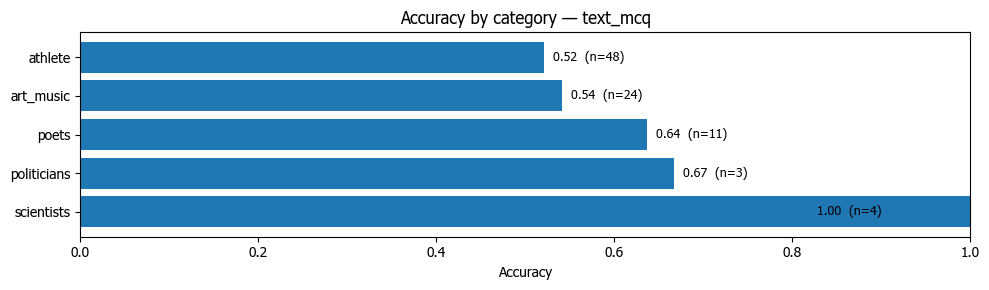

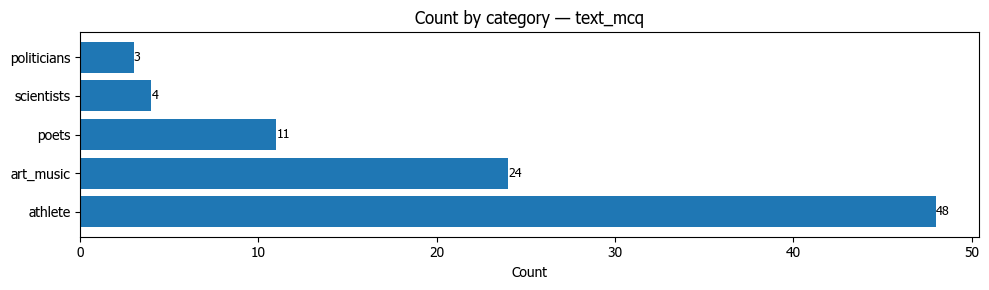

Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\per_question_text_mcq.csv  (rows=90)
Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\hardest_text_mcq.csv  (rows=10)
Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\by_category_uni_noopt.csv  (rows=5)


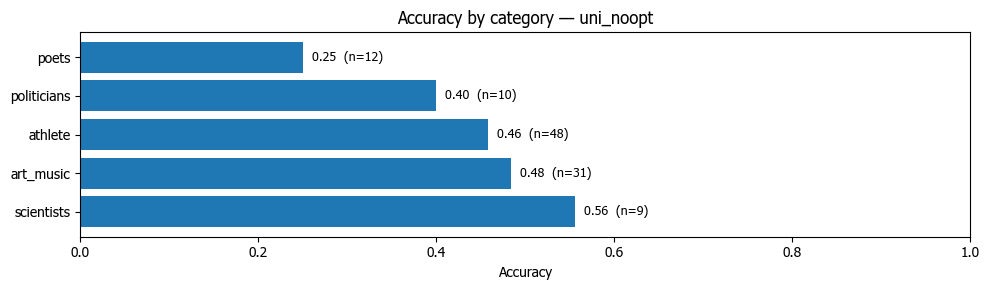

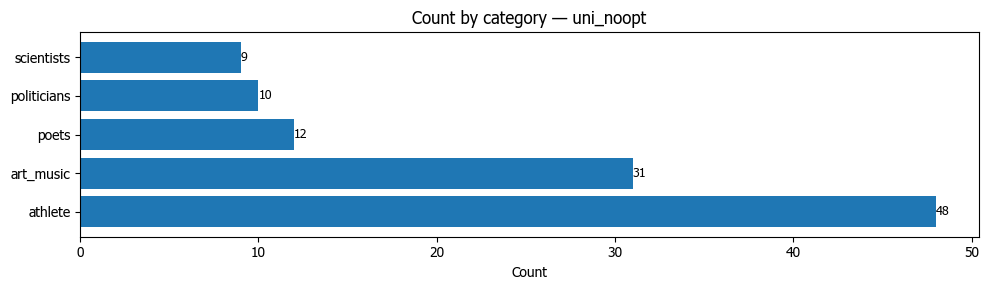

Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\per_question_uni_noopt.csv  (rows=110)
Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\hardest_uni_noopt.csv  (rows=10)
Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\by_category_multi_mcq.csv  (rows=4)


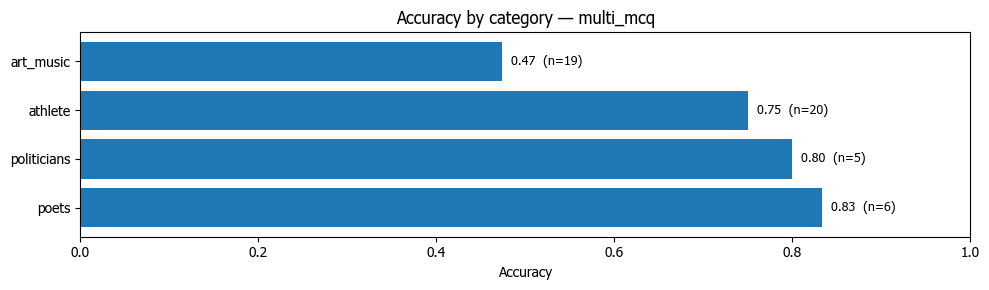

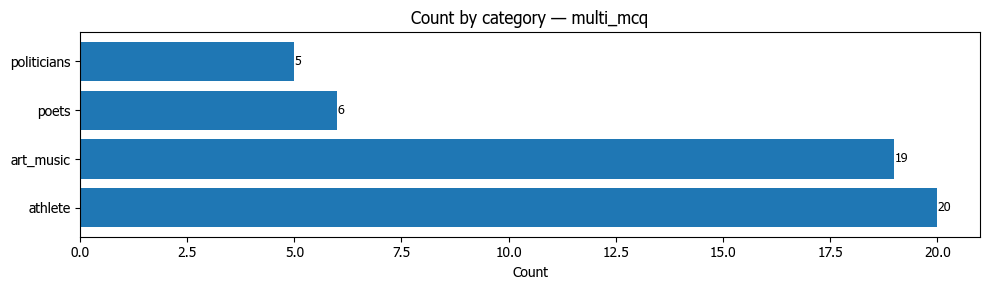

Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\per_question_multi_mcq.csv  (rows=50)
Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\hardest_multi_mcq.csv  (rows=10)
Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\by_category_multi_noopt.csv  (rows=4)


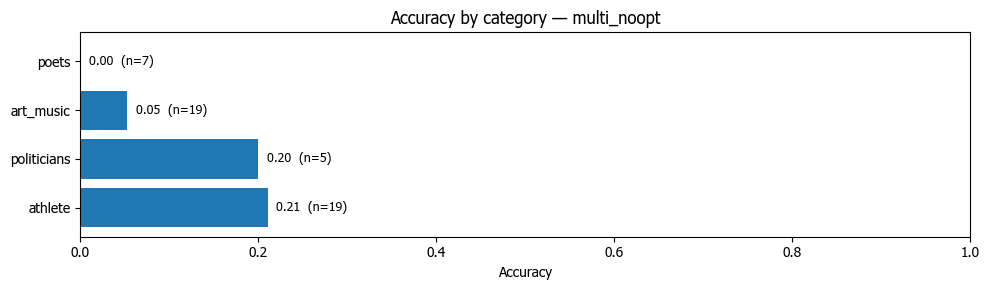

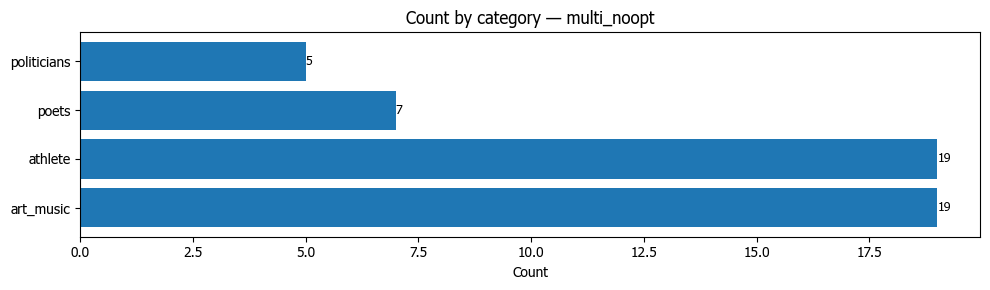

Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\per_question_multi_noopt.csv  (rows=50)
Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\hardest_multi_noopt.csv  (rows=10)


In [22]:
# Load
df_text_mcq   = load_df("text_mcq")
df_uni_noopt  = load_df("uni_noopt")
df_multi_mcq  = load_df("multi_mcq")
df_multi_noopt= load_df("multi_noopt")

# Evaluate per-set
summaries = []
bycat_all = []

for kind, df in [
    ("text_mcq", df_text_mcq),
    ("uni_noopt", df_uni_noopt),
    ("multi_mcq", df_multi_mcq),
    ("multi_noopt", df_multi_noopt),
]:
    s, cat = evaluate_set(kind, df)
    summaries.append(s)
    cat2 = cat.copy()
    cat2.insert(0, "set", kind)
    bycat_all.append(cat2)

Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\overall_summary.csv  (rows=4)


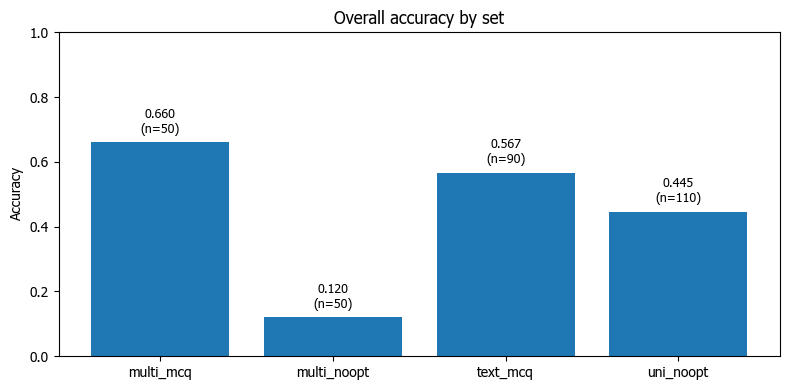

In [23]:
df_summary = pd.DataFrame(summaries).sort_values("set")
write_csv(df_summary, "overall_summary.csv")
plot_accuracy_by_set(df_summary, "Overall accuracy by set",
                     EVAL_DIR / "accuracy_by_set.png")

Wrote: G:\My Drive\NLP\project\rag_out\baseline\evaluation\agg_by_category_all_sets.csv  (rows=18)


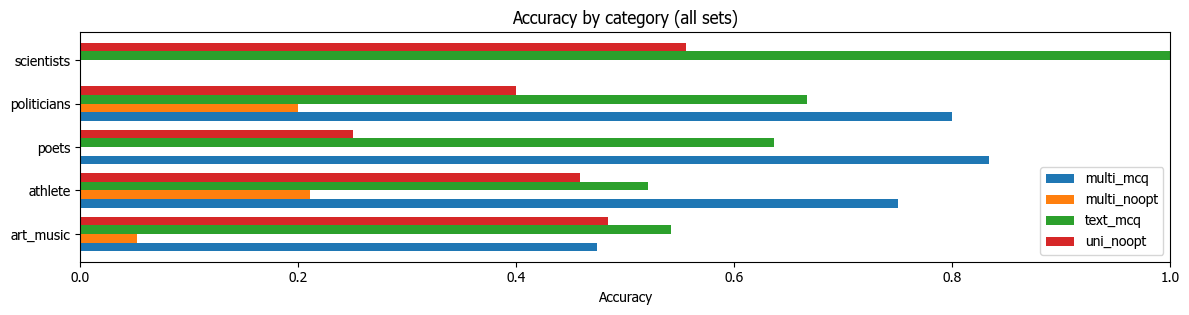

In [24]:
df_bycat_all = pd.concat(bycat_all, ignore_index=True)
write_csv(df_bycat_all, "agg_by_category_all_sets.csv")
plot_accuracy_by_category_all_sets(df_bycat_all,
                                   "Accuracy by category (all sets)",
                                   EVAL_DIR / "accuracy_by_category_all_sets.png")

In [30]:
from matplotlib.colors import ListedColormap

Path(EVAL_DIR).mkdir(parents=True, exist_ok=True)

In [33]:
def _to_int01(x):
    try:
        if isinstance(x, str):
            x = x.strip()
            if x == "": 
                return None
            if x.lower() in ("true","yes","y","بله"):
                return 1
        v = int(float(x))
        return 1 if v == 1 else 0
    except Exception:
        return None

def plot_answer_map(
    df_text_mcq: pd.DataFrame,
    df_uni_noopt: pd.DataFrame,
    df_multi_mcq: pd.DataFrame,
    df_multi_noopt: pd.DataFrame,
    n_max: int = 110,
    title: str = "Per-question correctness map",
    save_path: Path | str = None,
):
    sets = [
        ("Uni (Text) MCQ", df_text_mcq),
        ("Uni (no options)", df_uni_noopt),
        ("Multi (with image) MCQ", df_multi_mcq),
        ("Multi (no options)", df_multi_noopt),
    ]

    M = np.full((n_max, len(sets)), np.nan, dtype=float)
    for j, (_, df) in enumerate(sets):
        if "is_correct" not in df.columns:
            raise ValueError(f"Missing 'is_correct' in dataframe {j}")
        col = df["is_correct"].apply(_to_int01).tolist()
        L = min(len(col), n_max)
        for i in range(L):
            if col[i] is None:
                continue
            M[i, j] = float(col[i])

    cmap = ListedColormap(["#e74c3c", "#2ecc71"])
    M_masked = np.ma.masked_invalid(M)
    cmap.set_bad(color="#d0d0d0")

    fig = plt.figure(figsize=(6.5, 10))
    ax = plt.gca()
    im = ax.imshow(M_masked, aspect="auto", cmap=cmap, vmin=0, vmax=1)

    ax.set_title(title, fontsize=13, pad=10)
    ax.set_xlabel("Sets / Models")
    ax.set_ylabel("Question index")
    ax.set_xticks(range(len(sets)))
    ax.set_xticklabels([name for name, _ in sets], rotation=0)

    yticks = np.arange(0, n_max, 10)
    ax.set_yticks(yticks)
    ax.set_yticklabels([str(i+1) for i in yticks])

    ax.invert_yaxis()

    import matplotlib.patches as mpatches
    lgd = ax.legend(
        handles=[
            mpatches.Patch(color="#2ecc71", label="Correct"),
            mpatches.Patch(color="#e74c3c", label="Wrong"),
            mpatches.Patch(color="#d0d0d0", label="No row"),
        ],
        loc="upper right",
        frameon=True,
    )

    plt.tight_layout()
    if save_path is None:
        save_path = Path(EVAL_DIR) / "per_question_correctness_map.png"
    fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved figure:", save_path)

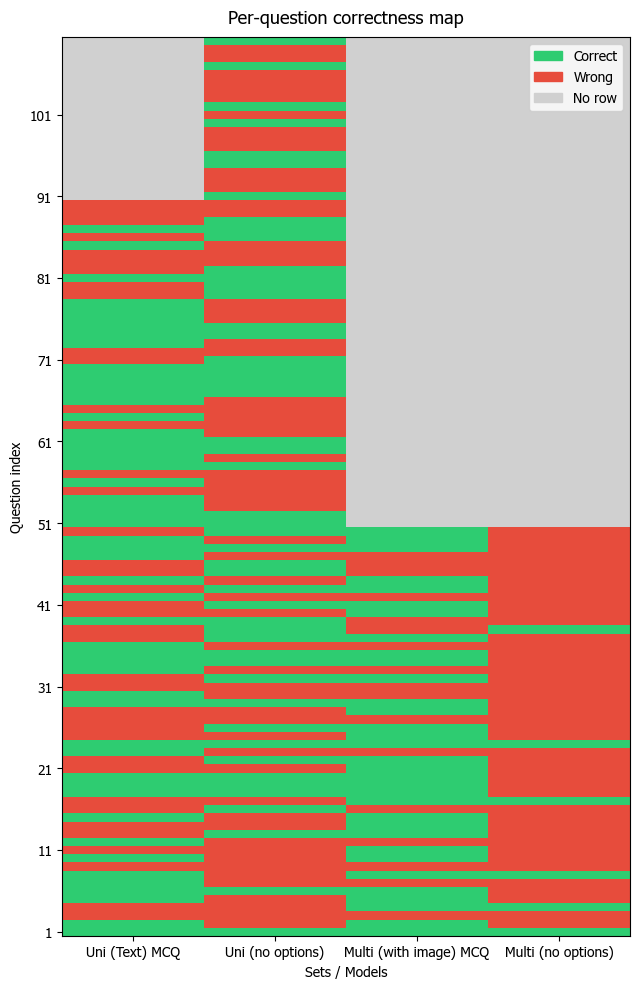

Saved figure: G:\My Drive\NLP\project\rag_out\baseline\evaluation\per_question_correctness_map.png


In [34]:
plot_answer_map(df_text_mcq, df_uni_noopt, df_multi_mcq, df_multi_noopt,
                n_max=110,
                title="Per-question correctness map",
                save_path=EVAL_DIR / "per_question_correctness_map.png")

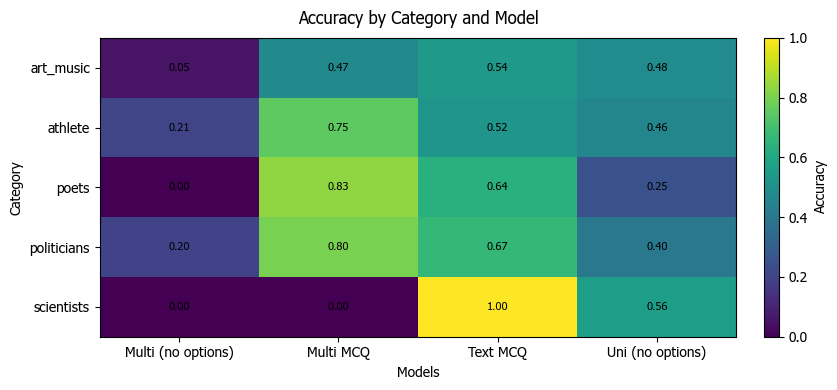

Saved: G:\My Drive\NLP\project\rag_out\baseline\evaluation\accuracy_heatmap_category_model.png


In [36]:
def _acc_by_category(df: pd.DataFrame, set_name: str) -> pd.DataFrame:
    if "category" not in df.columns or "is_correct" not in df.columns:
        raise ValueError(f"{set_name}: missing 'category' or 'is_correct'")
    tmp = df.copy()
    tmp["is_correct"] = pd.to_numeric(tmp["is_correct"], errors="coerce")
    out = (tmp.groupby("category", dropna=False)["is_correct"]
              .agg(acc="mean", n="size").reset_index())
    out["set"] = set_name
    return out

def plot_cat_model_heatmap(df_text_mcq, df_uni_noopt, df_multi_mcq, df_multi_noopt,
                           title="Accuracy by Category and Model",
                           save_path=None):
    frames = [
        _acc_by_category(df_text_mcq,   "Text MCQ"),
        _acc_by_category(df_uni_noopt,  "Uni (no options)"),
        _acc_by_category(df_multi_mcq,  "Multi MCQ"),
        _acc_by_category(df_multi_noopt,"Multi (no options)"),
    ]
    df = pd.concat(frames, ignore_index=True)
    pivot = df.pivot(index="category", columns="set", values="acc").fillna(0.0)
    fig, ax = plt.subplots(figsize=(8.5, max(4, 0.35*len(pivot))))
    im = ax.imshow(pivot.values, aspect="auto", vmin=0, vmax=1)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=0)
    ax.set_title(title, pad=10)
    ax.set_xlabel("Models")
    ax.set_ylabel("Category")
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            ax.text(j, i, f"{pivot.values[i,j]:.2f}", va="center", ha="center", fontsize=8)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Accuracy")
    plt.tight_layout()
    if save_path is None:
        save_path = EVAL_DIR / "accuracy_heatmap_category_model.png"
    fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", save_path)

plot_cat_model_heatmap(df_text_mcq, df_uni_noopt, df_multi_mcq, df_multi_noopt)

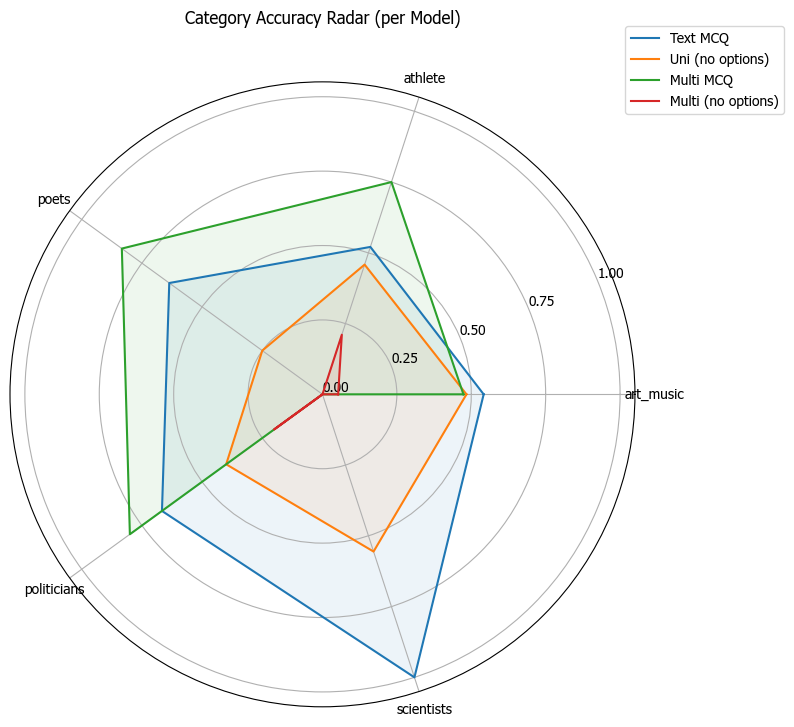

Saved: G:\My Drive\NLP\project\rag_out\baseline\evaluation\category_accuracy_radar.png


In [38]:
def _cat_acc_vector(df, label):
    g = (df.groupby("category")["is_correct"]
           .apply(lambda s: pd.to_numeric(s, errors="coerce").mean()))
    return g.sort_index(), label

def plot_radar_category_accuracy(df_text_mcq, df_uni_noopt, df_multi_mcq, df_multi_noopt,
                                 title="Category Accuracy Radar (per Model)",
                                 save_path=None):
    series = []
    for df,label in [
        (df_text_mcq, "Text MCQ"),
        (df_uni_noopt, "Uni (no options)"),
        (df_multi_mcq, "Multi MCQ"),
        (df_multi_noopt, "Multi (no options)")
    ]:
        s,_ = _cat_acc_vector(df, label)
        series.append((s, label))

    all_idx = sorted(set().union(*[s.index for s,_ in series]))
    mats, labels = [], []
    for s,label in series:
        mats.append(s.reindex(all_idx).fillna(0.0).values)
        labels.append(label)

    angles = np.linspace(0, 2*np.pi, len(all_idx), endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.set_title(title, y=1.08)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(all_idx)
    ax.set_yticks([0, .25, .5, .75, 1.0])
    ax.set_yticklabels(["0.00","0.25","0.50","0.75","1.00"])

    for vals, label in zip(mats, labels):
        v = vals.tolist() + vals[:1].tolist()
        ax.plot(angles, v, linewidth=1.5, label=label)
        ax.fill(angles, v, alpha=0.08)

    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))
    plt.tight_layout()
    if save_path is None:
        save_path = EVAL_DIR / "category_accuracy_radar.png"
    fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", save_path)

plot_radar_category_accuracy(df_text_mcq, df_uni_noopt, df_multi_mcq, df_multi_noopt)

C:\Users\sinab\AppData\Local\Temp\ipykernel_13016\3161987904.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, showfliers=False)


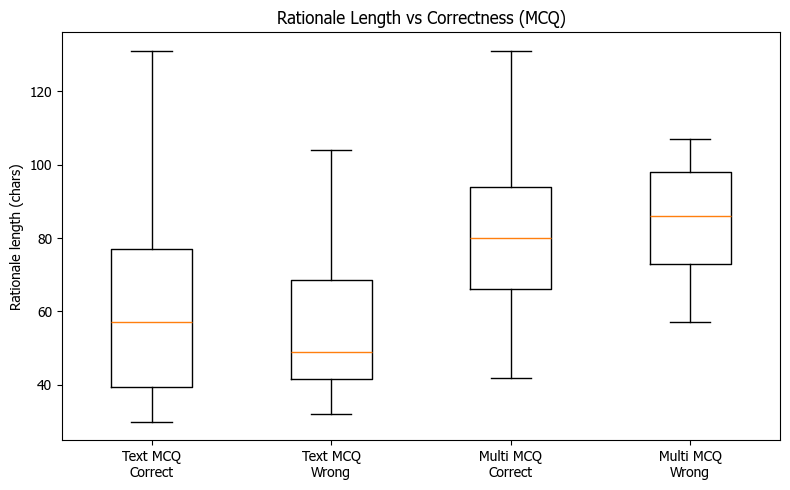

Saved: G:\My Drive\NLP\project\rag_out\baseline\evaluation\rationale_length_boxplots.png


In [42]:
def plot_rationale_length_boxplots(df_text_mcq, df_multi_mcq,
                                   title="Rationale Length vs Correctness (MCQ)",
                                   save_path=None):
    def prep(df, label):
        if "rationale" not in df.columns: 
            return pd.DataFrame(columns=["set","is_correct","len"])
        d = df.copy()
        d["len"] = d["rationale"].fillna("").astype(str).str.len()
        d["is_correct"] = pd.to_numeric(d["is_correct"], errors="coerce").fillna(0).astype(int)
        d["set"] = label
        return d[["set","is_correct","len"]]

    A = prep(df_text_mcq, "Text MCQ")
    B = prep(df_multi_mcq, "Multi MCQ")
    D = pd.concat([A, B], ignore_index=True)

    fig, ax = plt.subplots(figsize=(8,5))
    groups = []
    labels = []
    for sname in D["set"].unique():
        for ic in [1,0]:
            vals = D[(D["set"]==sname) & (D["is_correct"]==ic)]["len"].values
            if len(vals)==0: vals = np.array([np.nan])
            groups.append(vals)
            labels.append(f"{sname}\n{'Correct' if ic==1 else 'Wrong'}")

    ax.boxplot(groups, labels=labels, showfliers=False)
    ax.set_ylabel("Rationale length (chars)")
    ax.set_title(title)
    plt.tight_layout()
    if save_path is None:
        save_path = EVAL_DIR / "rationale_length_boxplots.png"
    fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", save_path)

plot_rationale_length_boxplots(df_text_mcq, df_multi_mcq)